In [1]:
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import os
import datetime
import pandas as pd
from scipy import stats

from palettable.colorbrewer.diverging import *
from palettable.colorbrewer.sequential import *
from calendar import monthrange

from osgeo import osr
import pyproj
from pyproj import Geod
from pyproj import Proj, transform
from fiona.crs import from_epsg

# Compare transect and scatter plots of 1 km, 3 km, and 1 km with interpolated topography

# 2015 A3D with 1 km topography

In [2]:
path = "/scratch/summit/erke2265/PRODUCTION/2015_WN/output/grids/a3d_grids_2015.nc"
ds_1 = xr.open_dataset(path)
n_trim = 15 # 15
ds_1 = ds_1.isel(easting=slice(n_trim, -n_trim))
ds_1 = ds_1.isel(northing=slice(n_trim, -n_trim))
km_smb = 1000 * (ds_1['swe'][-1,:,:] - ds_1['swe'][0,:,:])

In [3]:
min_smb = km_smb.min().values
max_smb = km_smb.max().values
color_lim = np.max([np.abs(min_smb), max_smb])

print(min_smb)
print(max_smb)
print(color_lim)

-31.806946
1128.9138
1128.9138


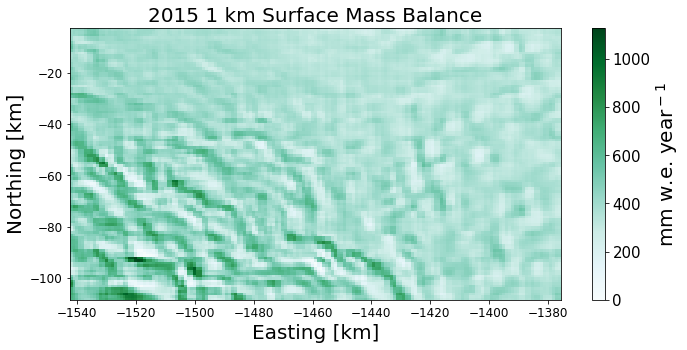

In [4]:
colormap = BuGn_9.mpl_colormap

plt.figure(figsize=(11, 5))
plt.pcolor(ds_1['easting']/1000, ds_1['northing']/1000, km_smb, cmap=colormap, vmin=0, vmax=color_lim, linewidth=0, rasterized=True)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=15)
cb.set_label("mm w.e. year$^-$$^1$", fontsize=20)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlabel("Easting [km]", fontsize=20)
plt.ylabel("Northing [km]", fontsize=20)
plt.title("2015 1 km Surface Mass Balance", fontsize=20)
plt.savefig("images/1smb.pdf", format='pdf', dpi=100, bbox_inches='tight')

# 2015 SMB with 3 km topography

In [5]:
path = "/scratch/summit/erke2265/PRODUCTION/2015_3km/output/grids/a3d_grids_2015.nc"
ds_3 = xr.open_dataset(path)
n_trim = 5
ds_3 = ds_3.isel(easting=slice(n_trim, -n_trim))
ds_3 = ds_3.isel(northing=slice(n_trim, -n_trim))
km_3_smb = 1000 * (ds_3['swe'][-1,:,:] - ds_3['swe'][0,:,:])

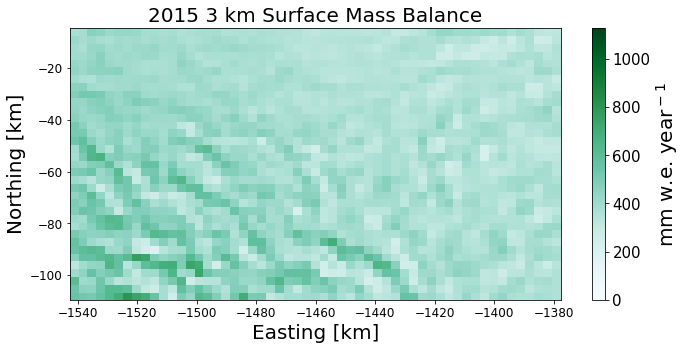

In [6]:
colormap = BuGn_9.mpl_colormap

plt.figure(figsize=(11, 5))
plt.pcolor(ds_3['easting']/1000, ds_3['northing']/1000, km_3_smb, cmap=colormap, vmin=0, vmax=color_lim, linewidth=0, rasterized=True)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=15)
cb.set_label("mm w.e. year$^-$$^1$", fontsize=20)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlabel("Easting [km]", fontsize=20)
plt.ylabel("Northing [km]", fontsize=20)
plt.title("2015 3 km Surface Mass Balance", fontsize=20)
plt.savefig("images/3smb.pdf", format='pdf', dpi=100, bbox_inches='tight')

# 2015 SMB with 1 --> 3 --> 1 km topography

In [7]:
path = "/scratch/summit/erke2265/PRODUCTION/2015_3km_1km/output/grids/a3d_grids_2015.nc"
ds_3_1 = xr.open_dataset(path)
n_trim = 15
ds_3_1 = ds_3_1.isel(easting=slice(n_trim, -n_trim))
ds_3_1 = ds_3_1.isel(northing=slice(n_trim, -n_trim))
km_3_1_smb = 1000 * (ds_3_1['swe'][-1,:,:] - ds_3_1['swe'][0,:,:])

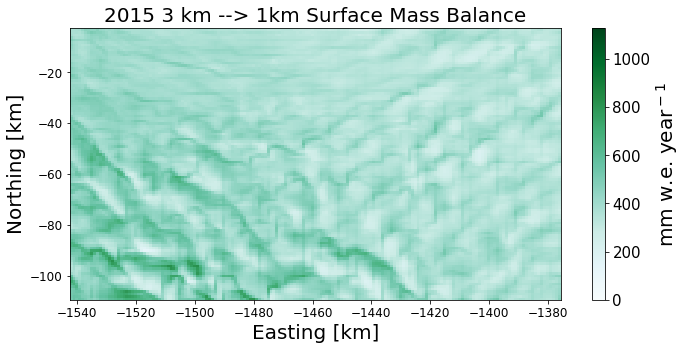

In [8]:
colormap = BuGn_9.mpl_colormap

plt.figure(figsize=(11, 5))
plt.pcolor(ds_3_1['easting']/1000, ds_3_1['northing']/1000, km_3_1_smb, cmap=colormap, vmin=0, vmax=color_lim, linewidth=0, rasterized=True)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=15)
cb.set_label("mm w.e. year$^-$$^1$", fontsize=20)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlabel("Easting [km]", fontsize=20)
plt.ylabel("Northing [km]", fontsize=20)
plt.title("2015 3 km --> 1km Surface Mass Balance", fontsize=20)
plt.savefig("images/3_1_smb.pdf", format='pdf', dpi=100, bbox_inches='tight')

# Transect

In [9]:
obs_lat, obs_lon, obs_accumulation, relative_accumulation, relative_accumulation_error = \
    np.loadtxt("/pl/active/nasa_smb/Data/Accumulation_Data_Product.csv", skiprows=1, delimiter=',', unpack=True)

In [10]:
# Source and target EPSG
src = osr.SpatialReference()
tgt = osr.SpatialReference()
src.ImportFromEPSG(4326) # WGS-84
tgt.ImportFromEPSG(3031) # South Polar Stereo

# Define transformation
transform = osr.CoordinateTransformation(src, tgt)

# Initialize arrays
obs_X = np.zeros(len(obs_lon)); obs_X[:] = np.nan
obs_Y = np.zeros(len(obs_lon)); obs_Y[:] = np.nan

# Perform transformation
for j in range(0, len(obs_X)):
    coords = transform.TransformPoint(obs_lat[j], obs_lon[j]) # Lat, Lon
    obs_X[j], obs_Y[j] = coords[0:2]

In [11]:
domain_left = ds_1['easting'].min()
domain_right = ds_1['easting'].max()
domain_bottom = ds_1['northing'].min()
domain_top = ds_1['northing'].max()

In [12]:
# Function to get indices of observations inside of the model domain
def get_domain_obs(obsX, obsY, obs_accum, domain_left, domain_right, domain_bottom, domain_top, obs_lat, obs_lon):
    '''
    Find obs whose X and Y are:
        X: greater than domain_left and less than domain_right
        Y: greater than domain_bottom and less than domain_top
    ''' 
    filter_func = np.vectorize(lambda obsX, obsY: obsX <= domain_right and obsX >= domain_left and obsY >= domain_bottom and obsY <= domain_top)
    indices = filter_func(obsX, obsY)
    obs_accum_filter = obs_accum[indices]
    obsX_filter = obsX[indices]
    obsY_filter = obsY[indices]
    obs_lat_filter = obs_lat[indices]
    obs_lon_filter = obs_lon[indices]
    
    return obsX_filter, obsY_filter, obs_accum_filter, obs_lat_filter, obs_lon_filter

# # Retrieve observations
obs_X, obs_Y, obs_accumulation, obs_lat, obs_lon = get_domain_obs(obs_X, obs_Y, obs_accumulation, domain_left, domain_right, domain_bottom, domain_top, obs_lat, obs_lon)

In [13]:
# Calculate seconds in each month from 2015 - 2020
seconds = np.zeros(12); seconds[:] = np.nan
count = -1
for year in range(2015, 2015 + 1):
    for month in range(1, 12 + 1):
        count = count + 1
        tmp = monthrange(year, month)
        seconds[count] = float(tmp[1]) * 24 * 60 * 60

# Path
data_path = "/scratch/summit/erke2265/MERRA2_monthly/"

# Precipitation
sn = xr.open_mfdataset(data_path + "PRECSN_monthly_2015.nc", combine='nested', concat_dim='time')
ls = xr.open_mfdataset(data_path + "PRECLS_monthly_2015.nc", combine='nested', concat_dim='time')
cu = xr.open_mfdataset(data_path + "PRECCU_monthly_2015.nc", combine='nested', concat_dim='time')

# Evaporation 
evap = xr.open_mfdataset(data_path + "EVAP_monthly_2015.nc", combine='nested', concat_dim='time')

# SMB
M2_smb = sn['PRECSN'] + ls['PRECLS'] + cu['PRECCU'] - evap['EVAP']
M2_smb = M2_smb.mean(dim='month').mean(dim='time') * seconds.mean() * 12

tgt_lon = xr.DataArray(obs_lon, dims="points")
tgt_lat = xr.DataArray(obs_lat, dims="points")
M2_transect = M2_smb.sel(lat=tgt_lat, lon=tgt_lon, method='nearest')

In [14]:
tgt_x = xr.DataArray(obs_X, dims="points")
tgt_y = xr.DataArray(obs_Y, dims="points")

a3d_transect =  km_smb.sel(northing=tgt_y, easting=tgt_x, method='nearest')
a3d_3km_transect =  km_3_smb.sel(northing=tgt_y, easting=tgt_x, method='nearest')
a3d_3_1_km_transect =  km_3_1_smb.sel(northing=tgt_y, easting=tgt_x, method='nearest')

# Indices to plot
ind0 = 660
indf = 2000
indices = np.arange(ind0, indf)

In [15]:
# Calculate distance along track (dat)
dat = np.zeros(len(indices)); dat[:] = np.nan
x0 = obs_X[ind0]; y0 = obs_Y[ind0]
count = -1 # Add hock index counter 

for j in range(ind0, indf):
    count = count + 1
    dat[count] = np.sqrt(np.square(obs_X[j] - x0) + np.square(obs_Y[j] - y0)) / 1000

460.6147720202481
459.24744
359.94882
380.45618
390.37872


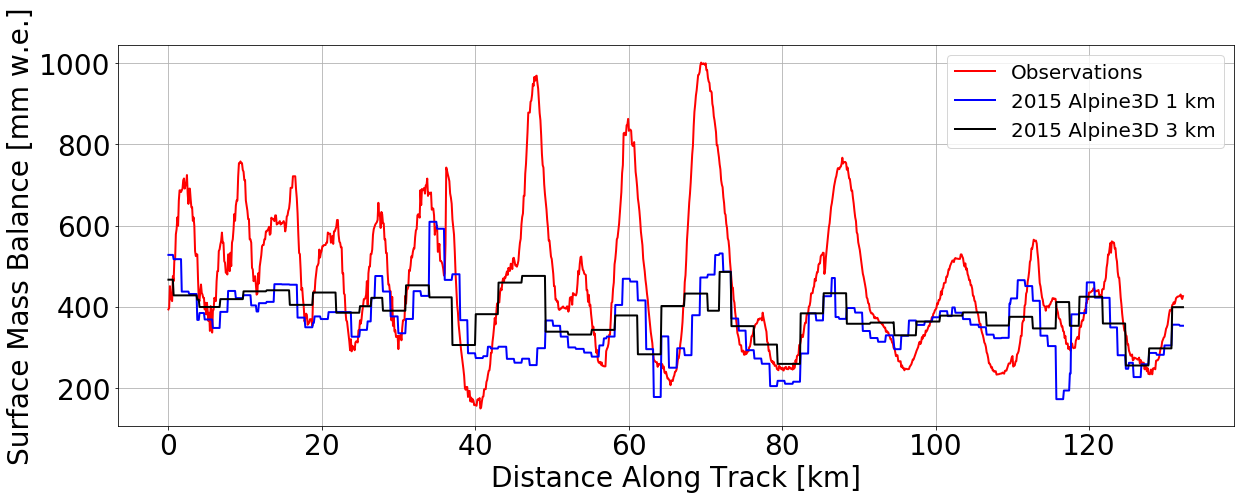

In [30]:
plt.figure(figsize=(20,7))
plt.plot(dat, 1000*obs_accumulation[indices], 'r', label='Observations', linewidth=2)
plt.plot(dat, a3d_transect[indices], 'b', label='2015 Alpine3D 1 km', linewidth=2)
plt.plot(dat, a3d_3km_transect[indices], 'k', label='2015 Alpine3D 3 km', linewidth=2)
# plt.plot(dat, a3d_3_1_km_transect[indices], 'm', label='2015 Alpine3D 3 km --> 1 km', linewidth=2)
# plt.plot(dat, M2_transect[indices], 'c', label='2015 MERRA-2', linewidth=2)
plt.grid()
plt.xticks(fontsize=28)
plt.yticks(fontsize=28)
plt.ylabel("Surface Mass Balance [mm w.e.]", fontsize=28)
plt.xlabel("Distance Along Track [km]", fontsize=28)
plt.legend(fontsize=20)
print(1000*obs_accumulation[indices].mean())
print(M2_transect[indices].mean().values)
print(a3d_transect[indices].mean().values)
print(a3d_3km_transect[indices].mean().values)
print(a3d_3_1_km_transect[indices].mean().values)

plt.savefig("images/transect.pdf", format='pdf', dpi=100, bbox_inches='tight')

In [17]:
def rmse(predictions, targets):
    return np.sqrt(((predictions - targets) ** 2).mean())

In [18]:
spacing = 10
obs_convulation = 1000 * np.convolve(obs_accumulation[indices], np.ones(spacing)/spacing, mode='valid')[::spacing]
M2_convulation = np.convolve(M2_transect[indices], np.ones(spacing)/spacing, mode='valid')[::spacing]
A3D_convulation = np.convolve(a3d_transect[indices], np.ones(spacing)/spacing, mode='valid')[::spacing]
A3D_3km_convulation = np.convolve(a3d_3km_transect[indices], np.ones(spacing)/spacing, mode='valid')[::spacing]
A3D_3_1_km_convulation = np.convolve(a3d_3_1_km_transect[indices], np.ones(spacing)/spacing, mode='valid')[::spacing]

In [19]:
x_1_to_1 = [-9999, 9999]
y_1_to_1 = [-9999, 9999]

p = 0.0023085938855032
R^2 = 0.06818132986181667
RMSE = 168.3135173850795
Average Bias = 128.5096673538683
Linear Fit Slope = 0.1098718251955722


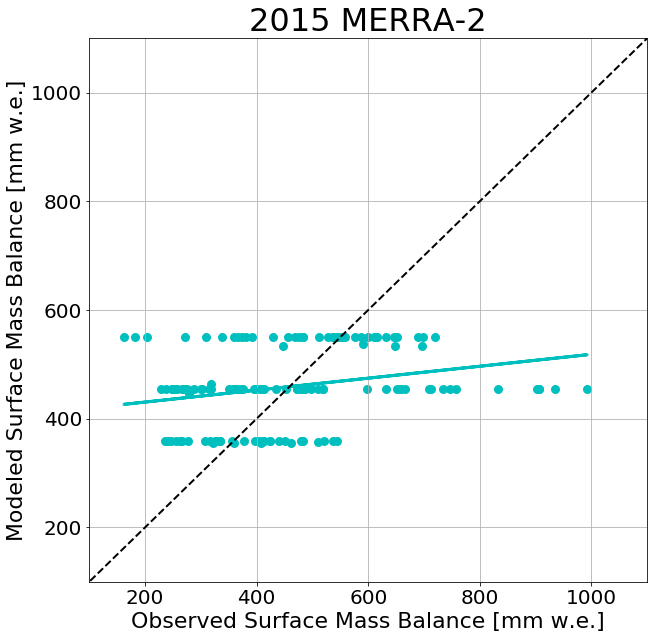

In [20]:
x = obs_convulation
y = M2_convulation
res = stats.linregress(x, y)

plt.figure(figsize=(10,10))
plt.scatter(x, y, c='c', linewidth=3)
plt.plot(x, res.intercept + res.slope*x, 'c', label='fitted line', linewidth=3)
plt.plot(x_1_to_1, y_1_to_1, 'k--', linewidth=2)
plt.xlim([100, 1100])
plt.ylim([100, 1100])
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.grid()
plt.title("2015 MERRA-2", fontsize=32)
plt.ylabel("Modeled Surface Mass Balance [mm w.e.]", fontsize=22)
plt.xlabel("Observed Surface Mass Balance [mm w.e.]", fontsize=22)
print("p = " + str(res.pvalue))
print("R^2 = " +str(res.rvalue**2))
print("RMSE = " + str(rmse(x, y)))
print("Average Bias = " + str(np.mean(np.abs(y - x))))
print("Linear Fit Slope = " + str(res.slope))
plt.savefig('images/2015-2020_M2_Scatter.pdf', format='pdf', dpi=100)

p = 1.3823358999456603e-12
R^2 = 0.3173454526416262
RMSE = 175.20708127111038
Average Bias = 127.39662649960307
Linear Fit Slope = 0.2548986805263731


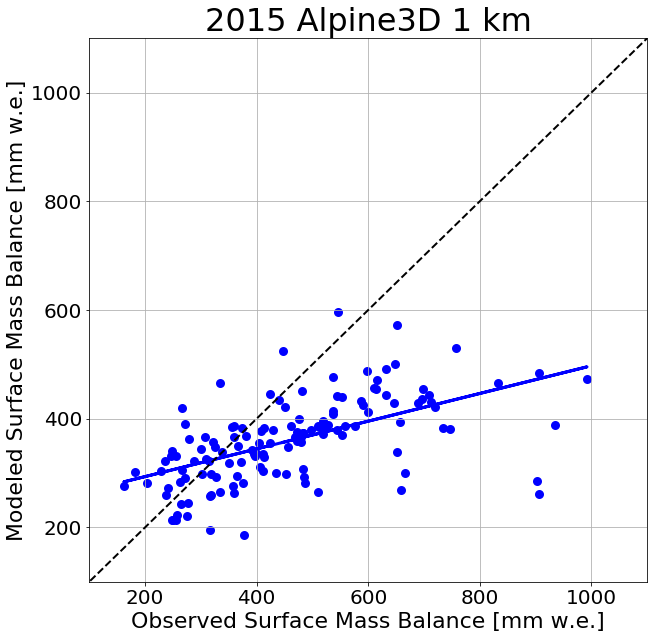

In [21]:
x = obs_convulation
y = A3D_convulation
res = stats.linregress(x, y)

plt.figure(figsize=(10,10))
plt.scatter(x, y, c='b', linewidth=3)
plt.plot(x, res.intercept + res.slope*x, 'b', label='fitted line', linewidth=3)
plt.plot(x_1_to_1, y_1_to_1, 'k--', linewidth=2)
plt.xlim([100, 1100])
plt.ylim([100, 1100])
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.grid()
plt.title("2015 Alpine3D 1 km", fontsize=32)
plt.ylabel("Modeled Surface Mass Balance [mm w.e.]", fontsize=22)
plt.xlabel("Observed Surface Mass Balance [mm w.e.]", fontsize=22)
print("p = " + str(res.pvalue))
print("R^2 = " +str(res.rvalue**2))
print("RMSE = " + str(rmse(x, y)))
print("Average Bias = " + str(np.mean(np.abs(y - x))))
print("Linear Fit Slope = " + str(res.slope))
plt.savefig('images/2015-2020_Alpine3D_Scatter.pdf', format='pdf', dpi=100)

p = 8.227179493198249e-15
R^2 = 0.3676641660017439
RMSE = 167.2852366156862
Average Bias = 121.20176193790684
Linear Fit Slope = 0.17956341979391477


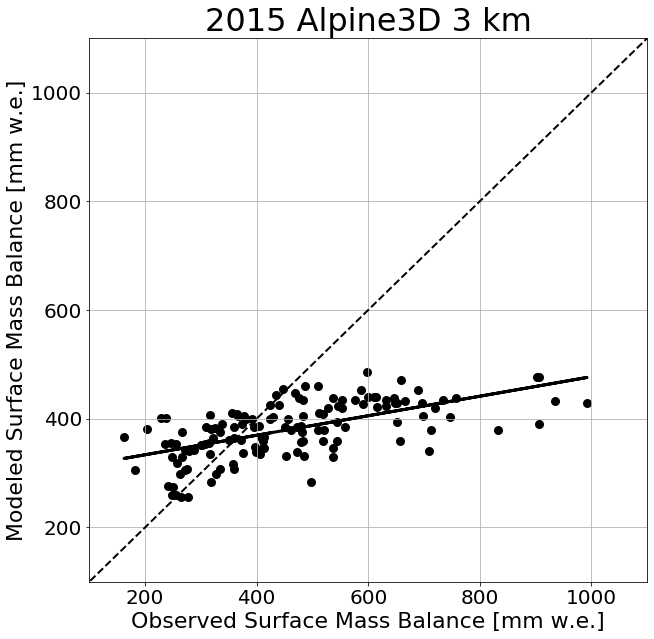

In [22]:
x = obs_convulation
y = A3D_3km_convulation
res = stats.linregress(x, y)

plt.figure(figsize=(10,10))
plt.scatter(x, y, c='k', linewidth=3)
plt.plot(x, res.intercept + res.slope*x, 'k', label='fitted line', linewidth=3)
plt.plot(x_1_to_1, y_1_to_1, 'k--', linewidth=2)
plt.xlim([100, 1100])
plt.ylim([100, 1100])
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.grid()
plt.title("2015 Alpine3D 3 km", fontsize=32)
plt.ylabel("Modeled Surface Mass Balance [mm w.e.]", fontsize=22)
plt.xlabel("Observed Surface Mass Balance [mm w.e.]", fontsize=22)
print("p = " + str(res.pvalue))
print("R^2 = " +str(res.rvalue**2))
print("RMSE = " + str(rmse(x, y)))
print("Average Bias = " + str(np.mean(np.abs(y - x))))
print("Linear Fit Slope = " + str(res.slope))
plt.savefig('images/2015-2020_Alpine3D_Scatter.pdf', format='pdf', dpi=100)

p = 8.56260676840606e-07
R^2 = 0.1682498786692317
RMSE = 171.89013995993642
Average Bias = 123.89385078283294
Linear Fit Slope = 0.1706213810805335


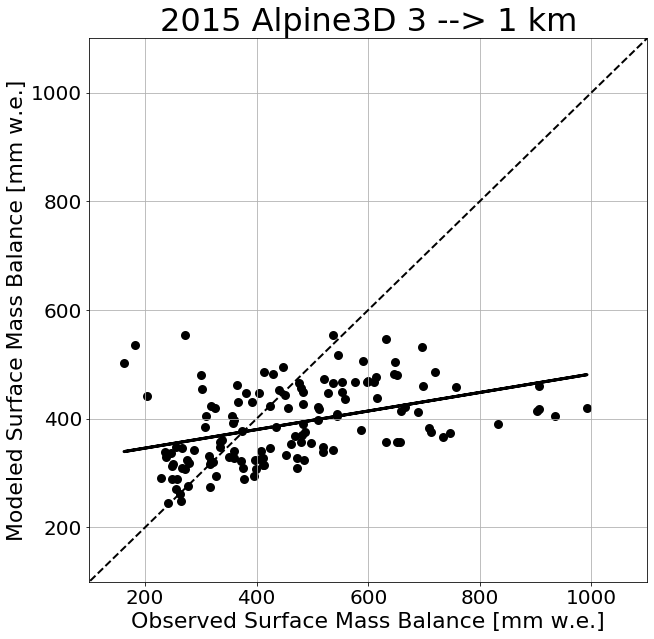

In [23]:
x = obs_convulation
y = A3D_3_1_km_convulation
res = stats.linregress(x, y)

plt.figure(figsize=(10,10))
plt.scatter(x, y, c='k', linewidth=3)
plt.plot(x, res.intercept + res.slope*x, 'k', label='fitted line', linewidth=3)
plt.plot(x_1_to_1, y_1_to_1, 'k--', linewidth=2)
plt.xlim([100, 1100])
plt.ylim([100, 1100])
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.grid()
plt.title("2015 Alpine3D 3 --> 1 km", fontsize=32)
plt.ylabel("Modeled Surface Mass Balance [mm w.e.]", fontsize=22)
plt.xlabel("Observed Surface Mass Balance [mm w.e.]", fontsize=22)
print("p = " + str(res.pvalue))
print("R^2 = " +str(res.rvalue**2))
print("RMSE = " + str(rmse(x, y)))
print("Average Bias = " + str(np.mean(np.abs(y - x))))
print("Linear Fit Slope = " + str(res.slope))
plt.savefig('images/2015-2020_Alpine3D_Scatter.pdf', format='pdf', dpi=100)

# Statistics

In [24]:
km_smb.mean()

<xarray.DataArray 'swe' ()>
array(393.8721, dtype=float32)

In [25]:
km_smb.std()

<xarray.DataArray 'swe' ()>
array(104.45951, dtype=float32)

In [26]:
km_3_smb.mean()

<xarray.DataArray 'swe' ()>
array(397.14508, dtype=float32)

In [27]:
km_3_smb.std()

<xarray.DataArray 'swe' ()>
array(74.813065, dtype=float32)

In [28]:
km_smb.std() / km_3_smb.std()

<xarray.DataArray 'swe' ()>
array(1.3962736, dtype=float32)

In [29]:
ds_1['WINDEROSIONDEPOSITION'].sum(dim='time').mean()

KeyboardInterrupt: 

In [ ]:
ds_3['WINDEROSIONDEPOSITION'].sum(dim='time').mean()